# Leer datasets

In [1]:
import pandas as pd
import numpy as np

circle = pd.read_csv('../data/circle.csv')
circle.head()

,X1,X2,label
0,-0.281529,0.141190,1
1,-0.164164,0.986075,0
2,-0.271517,0.014948,1
3,-0.670347,-0.657977,0
4,-0.826468,0.594071,0


In [2]:
circle.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(circle)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(circle)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(circle)
gmm_labels = gmm.predict(circle)

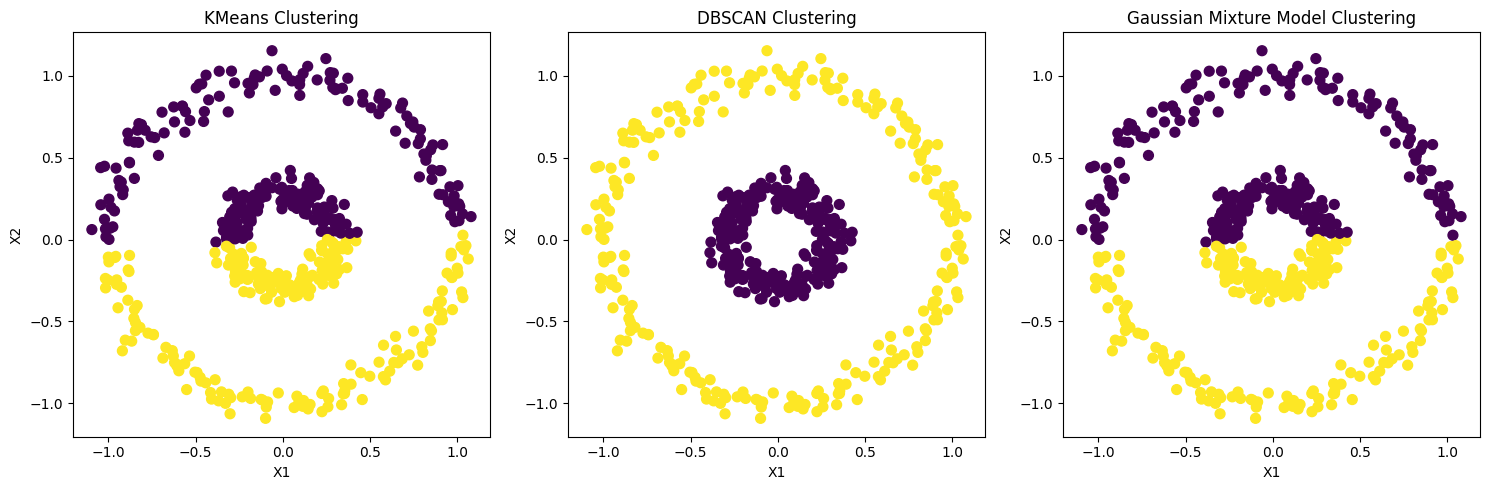

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(circle.iloc[:, 0], circle.iloc[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel(circle.columns[0])
plt.ylabel(circle.columns[1])
plt.subplot(1, 3, 2)
plt.scatter(circle.iloc[:, 0], circle.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel(circle.columns[0])
plt.ylabel(circle.columns[1])
plt.subplot(1, 3, 3)
plt.scatter(circle.iloc[:, 0], circle.iloc[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel(circle.columns[0])
plt.ylabel(circle.columns[1])
plt.tight_layout()
plt.show()

In [5]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(circle, kmeans_labels)
dbscan_silhouette = silhouette_score(circle, dbscan_labels)
gmm_silhouette = silhouette_score(circle, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.29
DBSCAN Silhouette Score: 0.21
Gaussian Mixture Model Silhouette Score: 0.29


# Interpretar

In [6]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [7]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(circle, kmeans_labels, test_size=0.2, random_state=42)


In [8]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [-0.01165837  0.41009725]
Cluster 1: [ 0.02099209 -0.41400679]


In [9]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.99


In [10]:
ripper.print_rules()


Reglas para clase: 0
[[X2=0.38-0.81] V [X2=0.00092-0.13] V [X2=>0.81] V [X2=0.13-0.25] V [X2=0.25-0.38]]

Reglas para clase: 1
[[X2=<-0.77] V [X2=-0.77--0.37] V [X2=-0.37--0.24] V [X2=-0.24--0.13] V [X2=-0.13-0.00092]]


Decision Tree Accuracy: 0.98


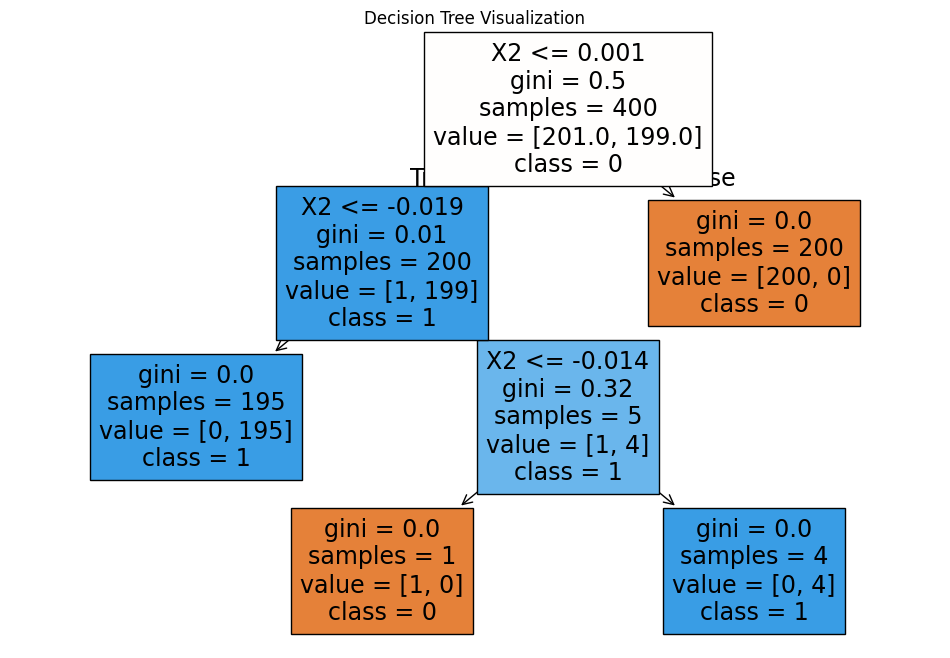

In [11]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=circle.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [12]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=circle.columns.tolist())


Optimization started

Training time: 13.83s, epochs: 200

Least training loss reached: 0.029


In [13]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.848] R6: 0.001 < X2 < 0.358
			0: 0.848	1: 0.000	Unc: 0.152

	[0.746] R7: X2 > 0.358
			0: 0.746	1: 0.000	Unc: 0.254

Most important rules for class 1

	[0.837] R5: -0.355 < X2 < 0.001
			0: 0.000	1: 0.837	Unc: 0.163

	[0.797] R4: X2 < -0.355
			0: 0.000	1: 0.797	Unc: 0.203


In [14]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.99


## DBSCAN

In [15]:
#dividir los datos en entrenamiento y prueba
n_clusters = len(np.unique(dbscan_labels))
max_label = np.max(dbscan_labels)
dbscan_labels = np.where(dbscan_labels == -1, max_label + 1, dbscan_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(circle, dbscan_labels, test_size=0.2, random_state=42)


In [16]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [17]:
r = ripper.get_rules()
string = str(r[0])
string1 = str(r[1])
rules = string.split('V')
rules1 = string1.split('V')
print("DBSCAN Ripper Rules:", len(rules))
print("DBSCAN Ripper Rules:", len(rules1))
ripper.print_rules()

DBSCAN Ripper Rules: 26
DBSCAN Ripper Rules: 6

Reglas para clase: 0
[[X2=-0.37--0.24^X1=-0.13-0.016] V [X1=-0.35--0.24] V [X1=-0.24--0.13^X2=0.13-0.25] V [X1=0.016-0.14^X2=-0.37--0.24] V [X1=0.14-0.28^X2=-0.24--0.13] V [X1=0.14-0.28^X2=-0.13-0.00092] V [X1=0.28-0.4^X2=-0.13-0.00092] V [X1=-0.24--0.13^X2=-0.13-0.00092] V [X2=0.25-0.38^X1=-0.13-0.016] V [X1=0.016-0.14^X2=0.25-0.38] V [X2=0.00092-0.13] V [X2=-0.24--0.13^X1=-0.13-0.016] V [X1=-0.24--0.13^X2=0.25-0.38] V [X2=0.13-0.25^X1=0.016-0.14] V [X2=-0.24--0.13^X1=-0.24--0.13] V [X2=0.13-0.25^X1=-0.13-0.016] V [X2=-0.37--0.24^X1=-0.24--0.13] V [X1=0.14-0.28^X2=0.25-0.38] V [X2=-0.24--0.13^X1=0.28-0.4] V [X1=0.14-0.28^X2=-0.37--0.24] V [X2=0.13-0.25^X1=0.14-0.28] V [X1=0.28-0.4^X2=0.13-0.25] V [X1=0.016-0.14^X2=-0.24--0.13] V [X1=-0.13-0.016^X2=-0.77--0.37] V [X1=0.016-0.14^X2=0.38-0.81] V [X2=-0.24--0.13^X1=-0.82--0.35]]

Reglas para clase: 1
[[X1=<-0.82] V [X2=<-0.77] V [X1=>0.82] V [X2=>0.81] V [X2=0.38-0.81] V [X2=-0.77--0.37]]


Decision Tree Accuracy: 1.00


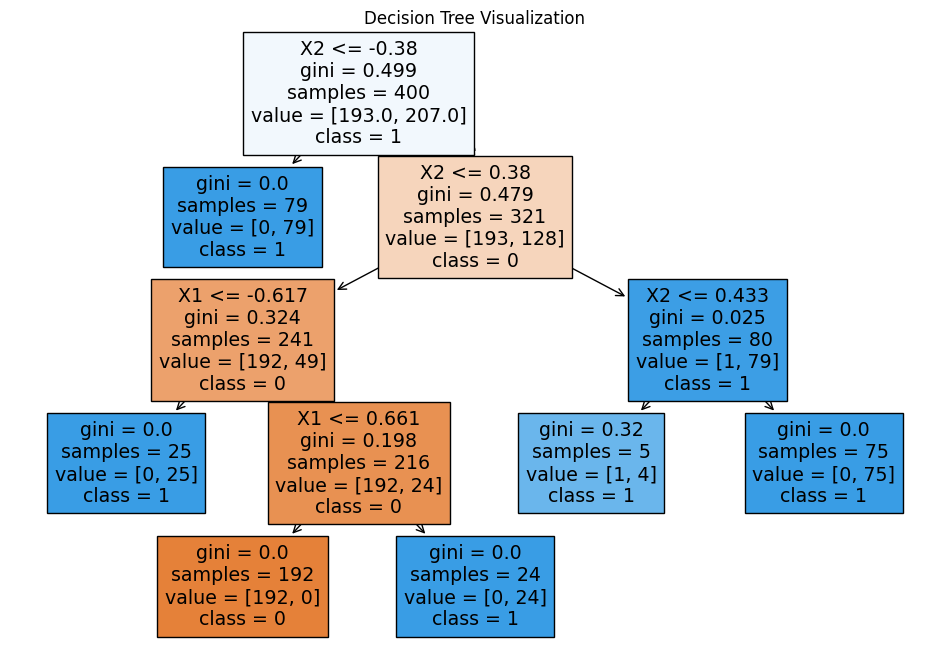

In [18]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=circle.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [19]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=circle.columns.tolist())


Optimization started

Training time: 13.18s, epochs: 200

Least training loss reached: 0.053


In [20]:
ds.print_most_important_rules(threshold=0.001)



Most important rules for class 0

	[0.583] R1: -0.341 < X1 < 0.018
			0: 0.583	1: 0.000	Unc: 0.417

	[0.576] R5: -0.355 < X2 < 0.001
			0: 0.576	1: 0.000	Unc: 0.424

	[0.571] R6: 0.001 < X2 < 0.358
			0: 0.571	1: 0.000	Unc: 0.429

	[0.533] R2: 0.018 < X1 < 0.377
			0: 0.533	1: 0.000	Unc: 0.467

Most important rules for class 1

	[0.788] R4: X2 < -0.355
			0: 0.000	1: 0.788	Unc: 0.212

	[0.780] R0: X1 < -0.341
			0: 0.000	1: 0.780	Unc: 0.220

	[0.779] R7: X2 > 0.358
			0: 0.000	1: 0.779	Unc: 0.221

	[0.751] R3: X1 > 0.377
			0: 0.000	1: 0.751	Unc: 0.249


In [21]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.98


## GMM

In [22]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(circle, gmm_labels, test_size=0.2, random_state=42)


In [23]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [24]:
ripper.print_rules()


Reglas para clase: 0
[[X2=0.38-0.81] V [X2=0.00092-0.13] V [X2=>0.81] V [X2=0.13-0.25] V [X2=0.25-0.38]]

Reglas para clase: 1
[[X2=<-0.77] V [X2=-0.77--0.37] V [X2=-0.37--0.24] V [X2=-0.24--0.13] V [X2=-0.13-0.00092]]


Decision Tree Accuracy: 0.99


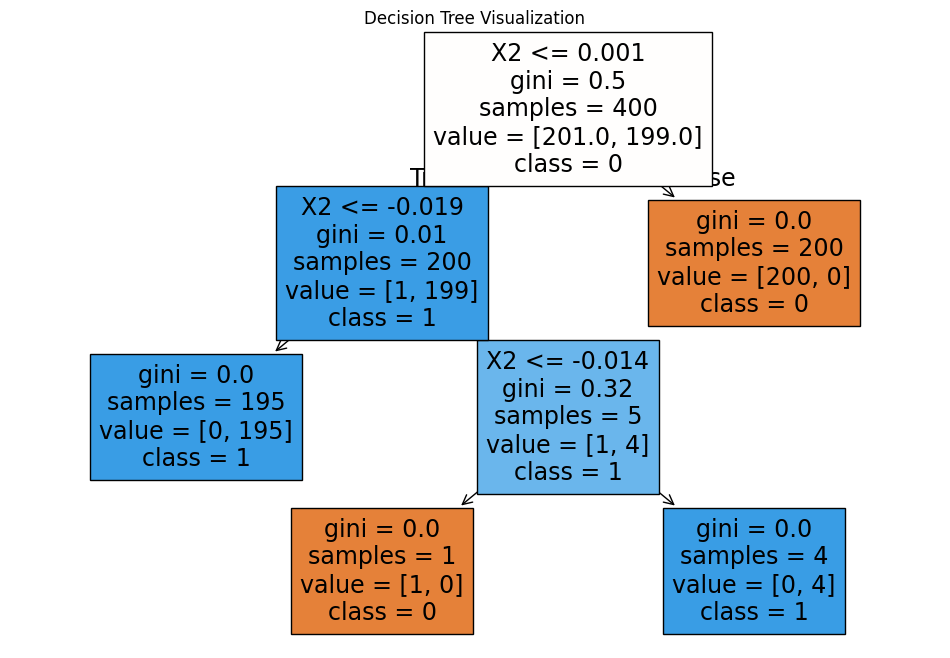

In [25]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=circle.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [26]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=circle.columns.tolist())


Optimization started

Training time: 13.59s, epochs: 200

Least training loss reached: 0.026


In [27]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.837] R7: X2 > 0.358
			0: 0.837	1: 0.000	Unc: 0.163

	[0.794] R6: 0.001 < X2 < 0.358
			0: 0.794	1: 0.000	Unc: 0.206

Most important rules for class 1

	[0.855] R4: X2 < -0.355
			0: 0.000	1: 0.855	Unc: 0.145

	[0.829] R5: -0.355 < X2 < 0.001
			0: 0.000	1: 0.829	Unc: 0.171


In [28]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00
